In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp
import hugegp_cuda as gp_cuda
import jaxkd as jk

import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(137)

In [3]:
rng, k1 = jr.split(rng)
points = jr.uniform(k1, (100,))
sorted = gp_cuda.primitive.sort(points)
sorted

Array([0.01972032, 0.04554367, 0.07365   , 0.08751154, 0.0915252 ,
       0.0915252 , 0.10421562, 0.13457   , 0.13457   , 0.13457   ,
       0.1356442 , 0.14800239, 0.14800239, 0.14800239, 0.14800239,
       0.16111445, 0.20045328, 0.20045328, 0.20189667, 0.21440685,
       0.21440685, 0.21779847, 0.23150063, 0.24440014, 0.24440014,
       0.24440014, 0.24457109, 0.24457109, 0.24639618, 0.24639618,
       0.24639618, 0.2670107 , 0.31155717, 0.31155717, 0.3134272 ,
       0.33403647, 0.34316146, 0.34880745, 0.34880745, 0.34880745,
       0.35931873, 0.34880745, 0.4013765 , 0.34880745, 0.42879045,
       0.34880745, 0.42879045, 0.34880745, 0.42879045, 0.34880745,
       0.438123  , 0.34880745, 0.438123  , 0.37374187, 0.46761477,
       0.42879045, 0.48211336, 0.48211336, 0.48215306, 0.48215306,
       0.48215306, 0.48215306, 0.48215306, 0.48215306, 0.48215306,
       0.519313  , 0.52242017, 0.52242017, 0.52242017, 0.52242017,
       0.52242017, 0.53049004, 0.53049004, 0.5388714 , 0.55514

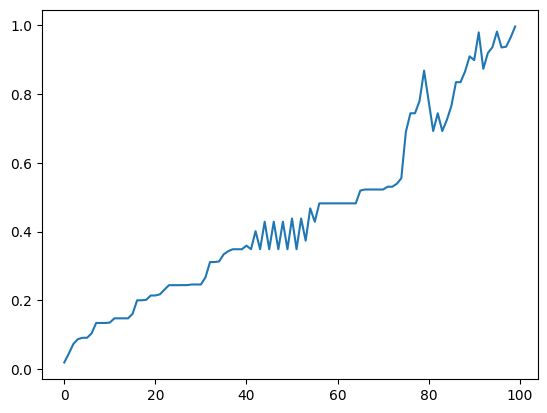

In [4]:
plt.plot(sorted)

In [4]:
rng, k1 = jr.split(rng)
points = jr.uniform(k1, (2**26,))
jnp.sort(points)

Array([0.0000000e+00, 0.0000000e+00, 1.1920929e-07, ..., 9.9999988e-01,
       9.9999988e-01, 9.9999988e-01], dtype=float32)

In [3]:
def estimate_memory(jitted_function, *args, **kwargs):
    stats = jitted_function.lower(*args, **kwargs).compile().memory_analysis()
    total_mem = stats.temp_size_in_bytes + stats.argument_size_in_bytes + stats.output_size_in_bytes
    return total_mem / 1024**3

In [18]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, shape=(10_000_000, 2))

In [19]:
points, split_dims, indices = gp.build_tree(points)
points[0]
estimate_memory(gp.build_tree, points)

0.5215419083833694

In [20]:
0.52 * 100

52.0

In [6]:
neighbors = gp.query_preceding_neighbors(points, split_dims, n0=1000, k=8, cuda=True)
neighbors[0]
estimate_memory(jax.jit(Partial(gp.query_preceding_neighbors, n0=1000, k=8, cuda=True)), points, split_dims)

0.40975213050842285

In [7]:
depths = gp.graph.compute_depths(neighbors, n0=1000, cuda=True)
depths[0]
estimate_memory(jax.jit(Partial(gp.graph.compute_depths, n0=1000, cuda=True)), neighbors)

0.33524632453918457

In [14]:
points, indices, neighbors, depths = gp.graph.order_by_depth(points, indices, neighbors, depths)
points[0]
estimate_memory(gp.graph.order_by_depth, points, indices, neighbors, depths)

0.931263267993927

In [10]:
graph = gp.build_graph(points, n0=1000, k=8, cuda=True)
covariance = (gp.make_cov_bins(r_min=1e-4, r_max=10, n_bins=1000), gp.MaternCovariance(p=0))

In [13]:
estimate_memory(gp.generate_jit, graph, covariance, jnp.zeros(len(points)), cuda=True)

0.5215222164988518

In [ ]:
values = gp.generate_jit(graph, (cov_bins, covariance), xi)
xi_back = gp.generate_inv_jit(graph, (cov_bins, covariance), values)
values_back = gp.generate_jit(graph, (cov_bins, covariance), xi_back)

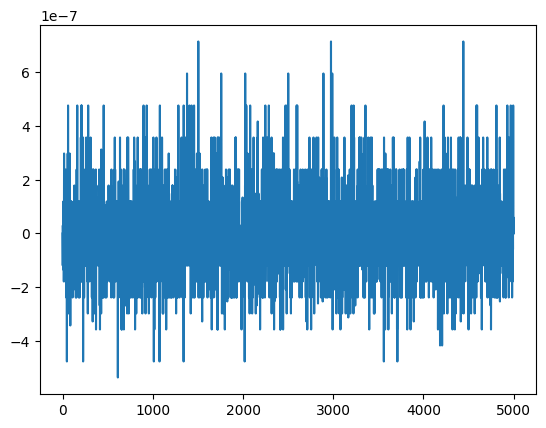

In [ ]:
plt.plot(values - values_back)

In [ ]:
cuda_values = gp.generate(graph, (cov_bins, covariance), xi, cuda=True)
cuda_values

Array([-0.84527874, -0.33612138,  0.41439384, ...,  0.11314134,
        1.2413161 , -2.211014  ], dtype=float32)

(-0.0001, 0.0001)

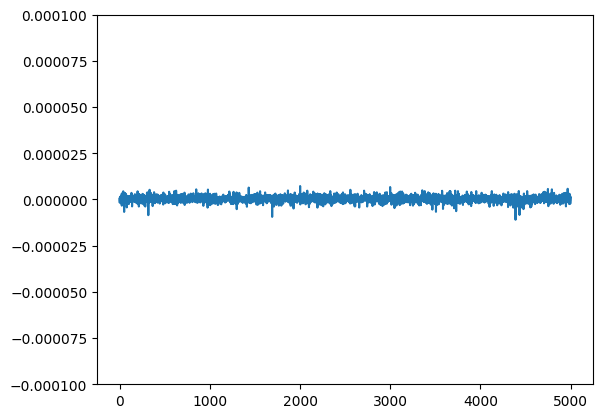

In [ ]:
plt.plot(values - cuda_values)
plt.ylim(-1e-4, 1e-4)

In [ ]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, shape=(len(points),))
values = gp.generate(graph, gp.MaternCovariance(p=0), xi)
values

Array([1.2794071 , 1.738562  , 0.7178262 , ..., 0.76837796, 1.2322326 ,
       0.5416563 ], dtype=float32)

# Inspect variance

In [ ]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(5_000, 2))
graph = gp.build_graph(points, n0=100, k=16)
covariance = gp.MaternCovariance(p=0)

In [ ]:
func = Partial(gp.generate, graph, covariance)
test_xi = jnp.zeros(len(points))
J = jax.jit(jax.jacfwd(func))(test_xi)
K = J @ J.T

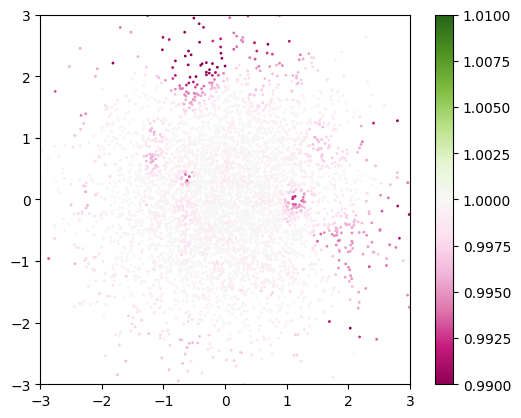

In [ ]:
sigma = jnp.sqrt(jnp.diag(K))

plt.scatter(*points.T, c=sigma, cmap='PiYG', s=1, vmin=0.99, vmax=1.01)
plt.gca().set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.colorbar()
plt.show()